In [ ]:
from glob import glob
import cv2 as cv
import matplotlib.pyplot as plt
import os
import time
import numpy as np
plt.rcParams["image.cmap"]="gray"

# <font style="color:rgb(0,0,0)">Load and read images</font>

In [ ]:
data =glob(r"D:\users\Downloads\images\*\*.jpg")
len(data),type(data)

(3600, list)

In [ ]:
data1=[]
for i in range(3600):
    data1.append(cv.imread(data[i],1))


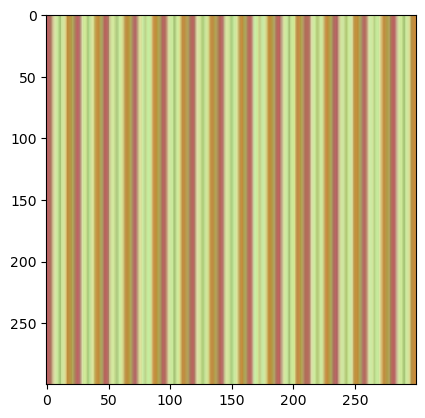

In [ ]:
plt.imshow(data1[0][:,:,::-1])

In [ ]:
import numpy as np

images= []

for n in range(0,len(data1)):
    images.append(np.array(data1[n]))

In [ ]:
import cv2
bw_images = []
for img in images:
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        bw_images.append(img)

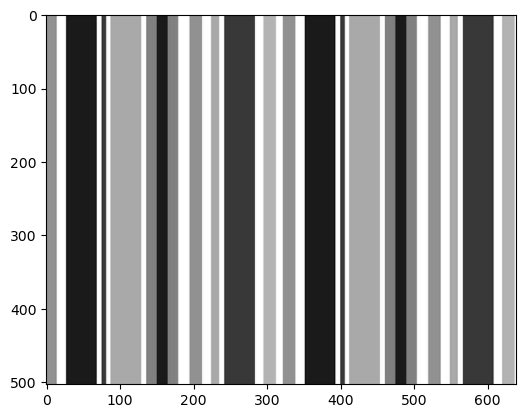

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1])
plt.show()

# <font style="color:rgb(0,0,0)">Extract Features by SIFT</font>

In [ ]:
extractor = cv.SIFT_create()
keypoints = []
descriptors = []
for img in bw_images:
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
print(len(descriptors))
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    if img_descriptors is None:
        to_drop.append(i)

print(to_drop)
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(len(descriptors))

3600
[0, 1, 3, 5, 6, 8, 9, 10, 16, 18, 20, 25, 28, 29, 35, 41, 43, 44, 45, 50, 51, 52, 53, 63, 64, 66, 67, 70, 88, 103, 115, 144, 149, 182, 602, 966, 975, 980, 994, 995, 1037, 1859, 1900, 1934, 1979, 2068, 2085, 2086, 2087, 2088, 2152, 2173, 2261, 2644, 2657, 2662, 2667, 2671, 2681, 2683, 2706, 2714, 2716, 2717, 2719, 2722, 3511, 3520, 3521, 3534]
3530


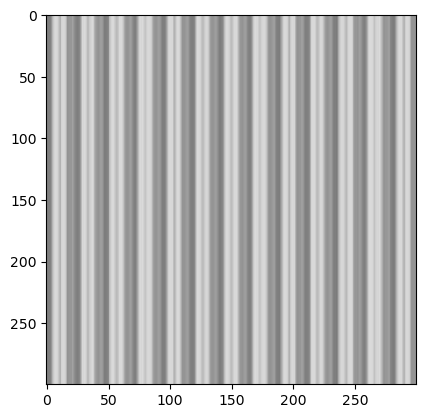

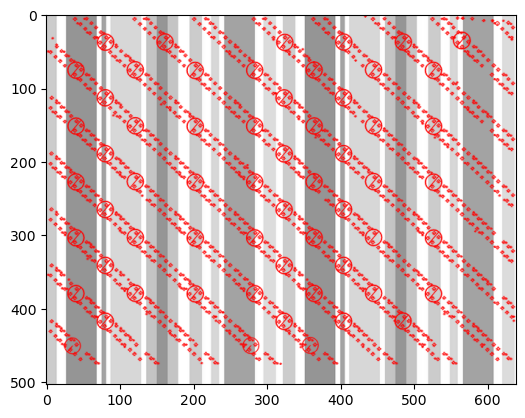

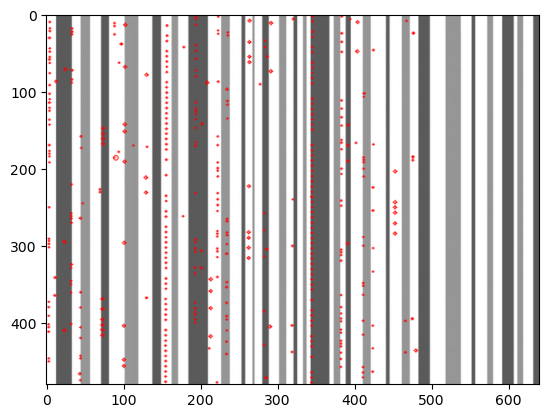

In [ ]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 0, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x])
    plt.show()

In [ ]:
import numpy as np
np.random.seed(0)
sample_idx = np.random.randint(0, 3530, 500).tolist()
len(sample_idx)
descriptors[2933]

array([[114.,   4.,   1., ...,  15., 118.,  93.],
       [  4.,   8.,  31., ...,   2.,   5., 122.],
       [ 38.,  89.,   2., ...,   4.,   2.,   2.],
       ...,
       [  0.,   0.,   0., ...,   1.,   3.,   6.],
       [ 78.,   2.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   8.,  52.,  18.]], dtype=float32)

In [ ]:
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [ ]:
np.array(descriptors_sample).shape

C:\Users\facebook\AppData\Local\Temp\ipykernel_15228\1484170124.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(descriptors_sample).shape


(500,)

In [ ]:
all_descriptors = []
for img_descriptors in descriptors_sample:
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
all_descriptors = np.stack(all_descriptors)

In [ ]:
all_descriptors.shape

(1304370, 128)

In [ ]:
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
print(count[:5])
print(sum(count))

[92, 148, 912, 2179, 4043]
1304370


# <font style="color:rgb(0,0,0)">Cluster Descriptors using K-Means</font>

In [ ]:
from scipy.cluster.vq import kmeans

k = 250
iters = 4
codebook, variance = kmeans(all_descriptors, k, iters)

In [ ]:
import joblib
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [ ]:
k, codebook = joblib.load("bovw-codebook.pkl")

# <font style="color:rgb(0,0,0)">Quantize Image Features</font>

In [ ]:
from scipy.cluster.vq import vq
visual_words = []
for img_descriptors in descriptors:
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
visual_words[0][:5], len(visual_words[0])

(array([139, 139, 109, 109, 109]), 46)

# <font style="color:rgb(0,0,0)">TF-IDF Normalization</font>

In [ ]:
frequency_vectors = []
for img_visual_words in visual_words:
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

(3530, 250)

In [ ]:
for i in [84,  22,  45, 172]:
    print(frequency_vectors[0][i])

0.0
0.0
0.0
0.0


In [ ]:
frequency_vectors[0][:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

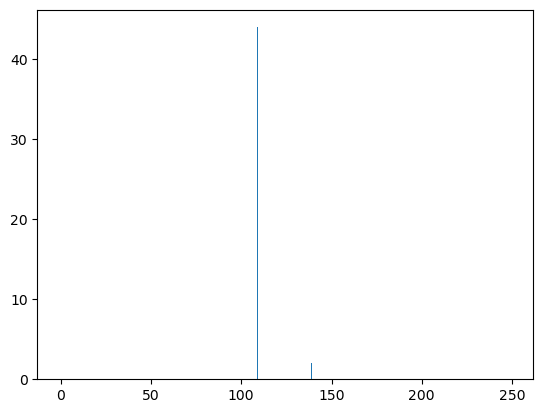

In [ ]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

In [ ]:
N = 3530
df = np.sum(frequency_vectors > 0, axis=0)

In [ ]:
df.shape, df[:5]

((250,), array([2505, 2502, 2195, 2010, 2169]))

In [ ]:
idf = np.log(N/ df)
idf.shape, idf[:5]

((250,), array([0.15807795, 0.15927627, 0.29018463, 0.37823196, 0.30210045]))

In [ ]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((3530, 250), array([0., 0., 0., 0., 0.]))

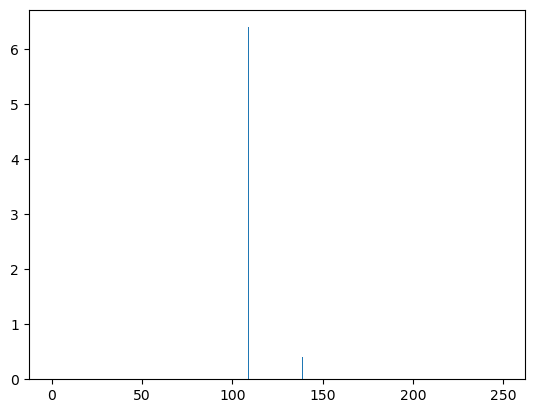

In [ ]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

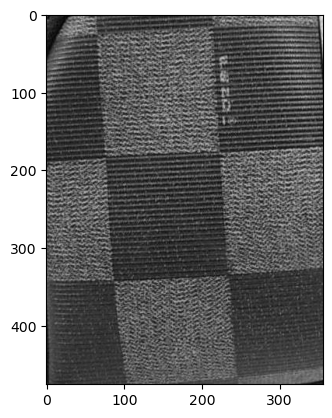

In [ ]:
search_i = 659
plt.imshow(bw_images[search_i])
plt.show()

# <font style="color:rgb(0,0,0)">Compute Cosine Similarity</font>


In [ ]:
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf
cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
print(round(np.min(cosine_similarity),1))
print(np.max(cosine_similarity))

0.0
1.0


In [ ]:
cosine_similarity.shape

(3530,)

In [ ]:
cosine_similarity

array([0.02537717, 0.00010916, 0.0225168 , ..., 0.00448377, 0.02483021,
       0.02579305])

In [ ]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([659, 621, 635, 677, 584], dtype=int64)

In [ ]:
cosine_similarity[idx[0]]

1.0

1.0


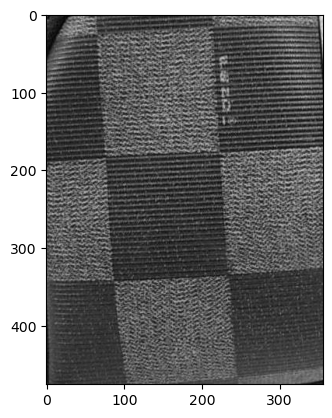

0.9348


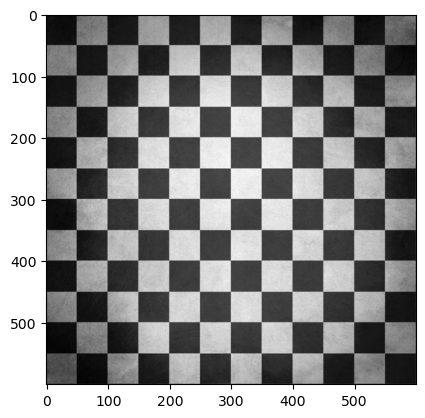

0.9279


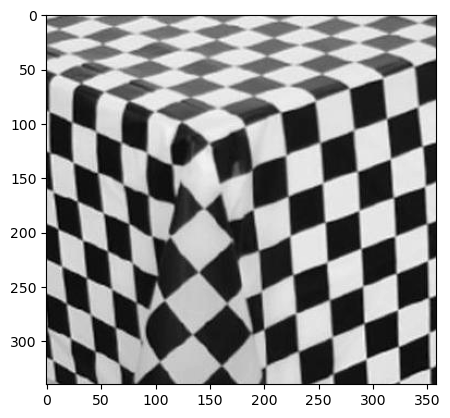

0.9037


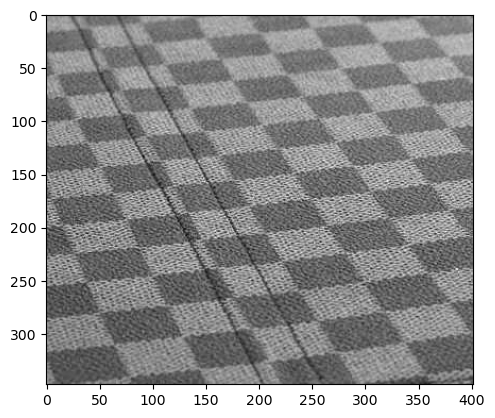

0.8897


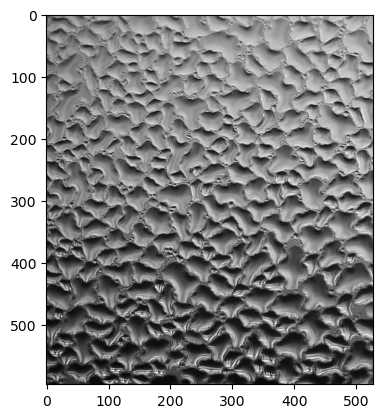

In [ ]:
for i in idx:
    print(round(cosine_similarity[i], 4))
    plt.imshow(bw_images[i])
    plt.show()

# <font style="color:rgb(0,0,0)">Searching for similar images</font>


In [ ]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    plt.imshow(bw_images[i])
    plt.show()
    a = tfidf[i]
    cosine_similarity = np.dot(a, b.T)/(norm(a) * norm(b, axis=1))
    idx = np.argsort(-cosine_similarity)[:top_k]
    for i in idx:
        print(round(cosine_similarity[i], 5))
        plt.imshow(bw_images[i])
        plt.show()

Search image:


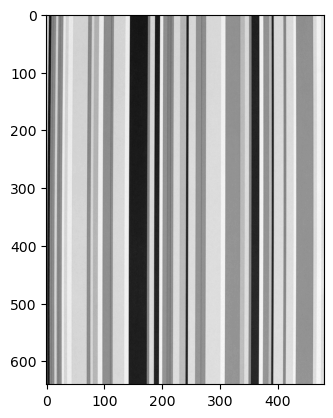

1.0


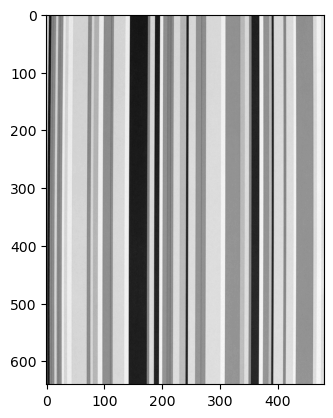

0.99822


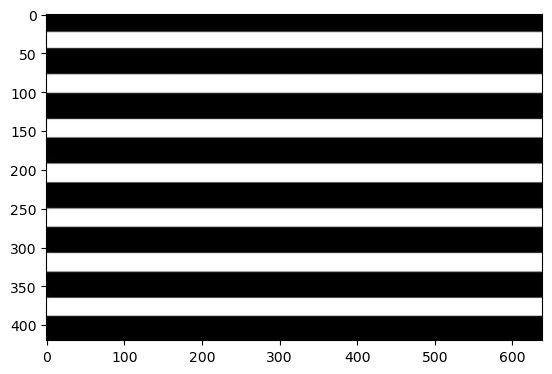

0.99259


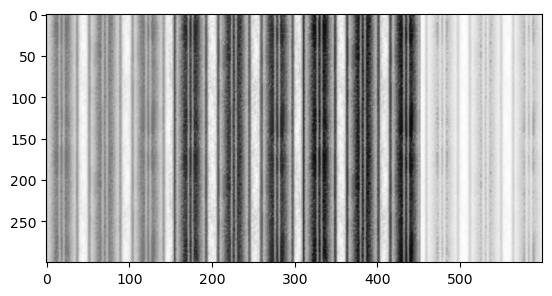

0.97442


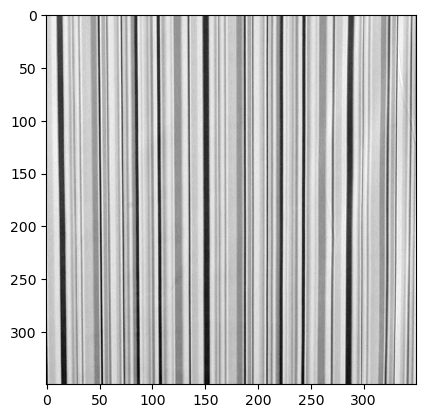

0.97395


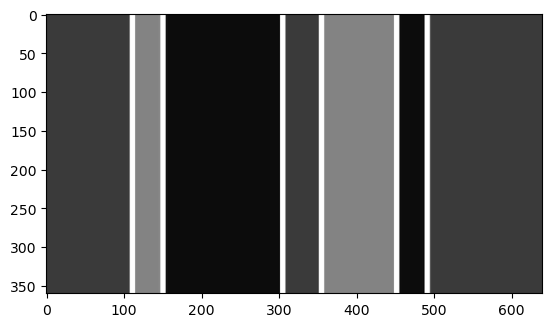

In [ ]:
search(10)

Search image:


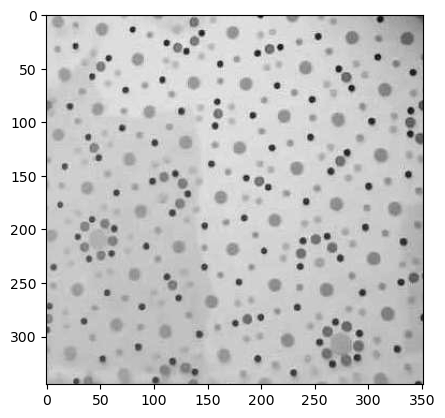

1.0


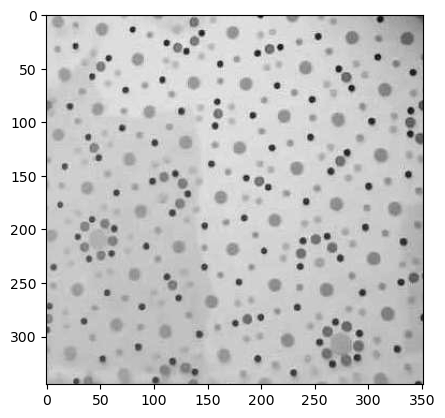

0.93746


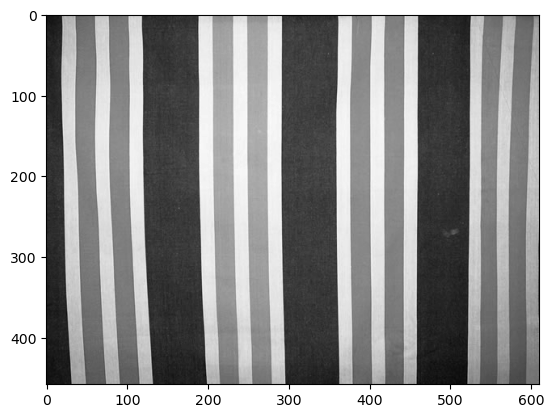

0.93647


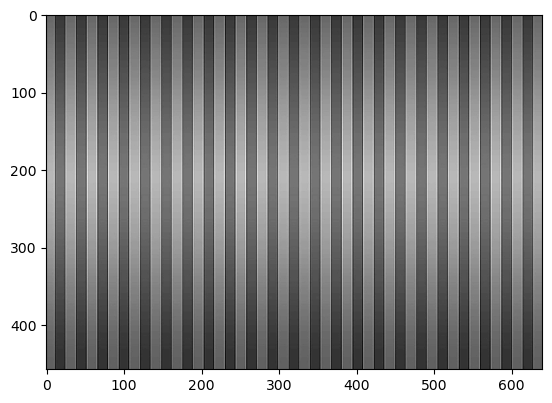

0.93344


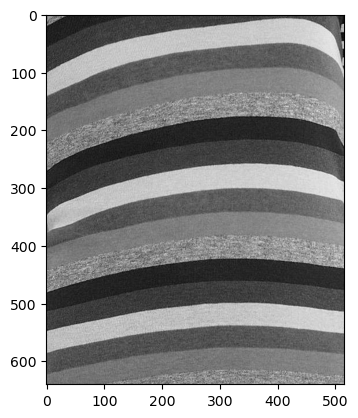

0.92905


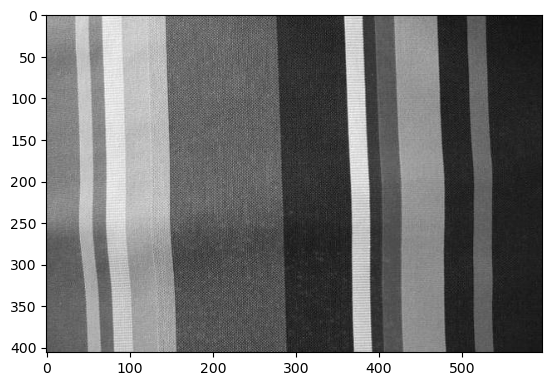

In [ ]:
search(1200)

# <font style="color:rgb(0,0,0)">Extract color features </font>


In [ ]:
data2=[]
for image in data1:
    data2.append(cv.resize(image,(120,120)))

---

In [ ]:
def get_vector(image, bins=32):
    red = cv.calcHist([image], [2], None, [16], [0, 256])/14400
    green = cv.calcHist([image], [1], None, [16], [0, 256])/14400
    blue = cv.calcHist([image], [0], None, [16], [0, 256])/14400
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector


In [ ]:
vec = get_vector(data1[0])
vec.shape

(48,)

In [ ]:
image_vectors = []
for image in data2 :
    image_vectors.append(get_vector(image))

In [ ]:
dist = np.linalg.norm(image_vectors[0] - image_vectors[1])
dist

0.7765885

# <font style="color:rgb(0,0,0)">Compute Cosine Similarity</font>


In [ ]:
def euclidean(a, b):
    return np.linalg.norm(a - b)
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# <font style="color:rgb(0,0,0)">Searching and Visualizing Similar Images </font>


In [ ]:
rgb_images = np.array([np.flip(image, 2) for image in images])

def search(idx, top_k=5):
    query_vector = image_vectors[idx]
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))
        sorted_indices = np.argsort(distances)[::-1]  # Sort in descending order
        top_results = sorted_indices[:top_k]
    return top_results

C:\Users\facebook\AppData\Local\Temp\ipykernel_24936\4028417953.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rgb_images = np.array([np.flip(image, 2) for image in images])


In [ ]:
search(0)

array([   0, 3545, 1624, 1792, 1393], dtype=int64)

In [ ]:
def visualize(query_i, results_i):
    query = rgb_images[query_i]
    span = int(len(image_vectors[0])/3)
    results = rgb_images[results_i]
    top_k = len(results)
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    axs[0].imshow(query)
    axs[0].axis('off')
    axs[1].plot(image_vectors[query_i][:span], 'r', label='red')
    axs[1].plot(image_vectors[query_i][span:span*2], 'g', label='green')
    axs[1].plot(image_vectors[query_i][span*2:], 'b', label='blue')
    plt.show()
    fig0, axs0 = plt.subplots(1, top_k, figsize=(top_k*5, 5))
    fig1, axs1 = plt.subplots(1, top_k, figsize=(top_k*5, 5), sharey=True)
    for i in range(top_k):
        axs0[i].imshow(results[i])
        axs0[i].axis('off')
        axs1[i].plot(image_vectors[results_i[i]][:span], 'r', label='red')
        axs1[i].plot(image_vectors[results_i[i]][span:span*2], 'g', label='green')
        axs1[i].plot(image_vectors[results_i[i]][span*2:], 'b', label='blue')

In [ ]:
time1=time.time()
results_i = search(0)
time2=time.time()
lattency=time2-time1

In [ ]:
results_i,lattency


(array([   0, 3545, 1624, 1792, 1393], dtype=int64), 0.6186103820800781)

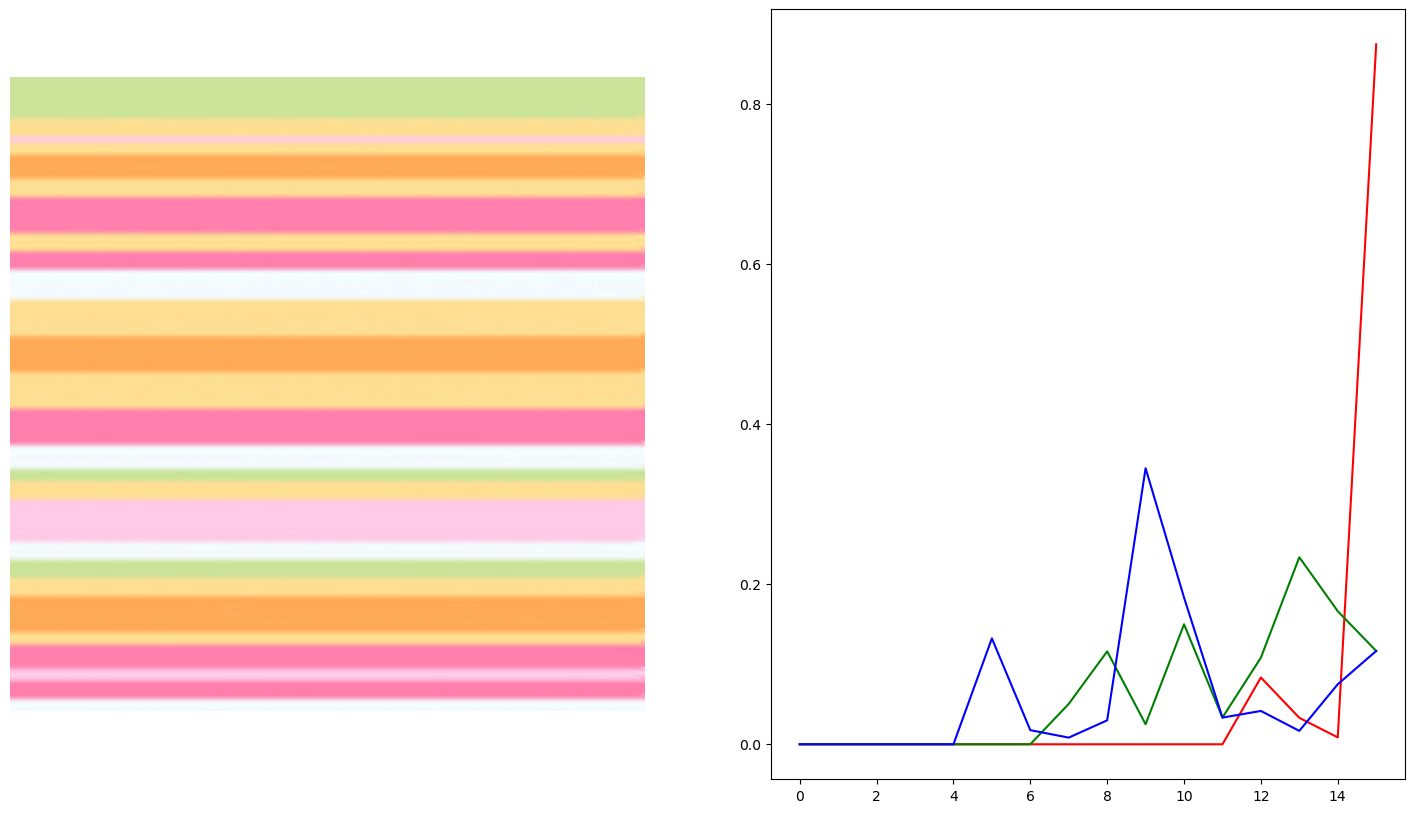

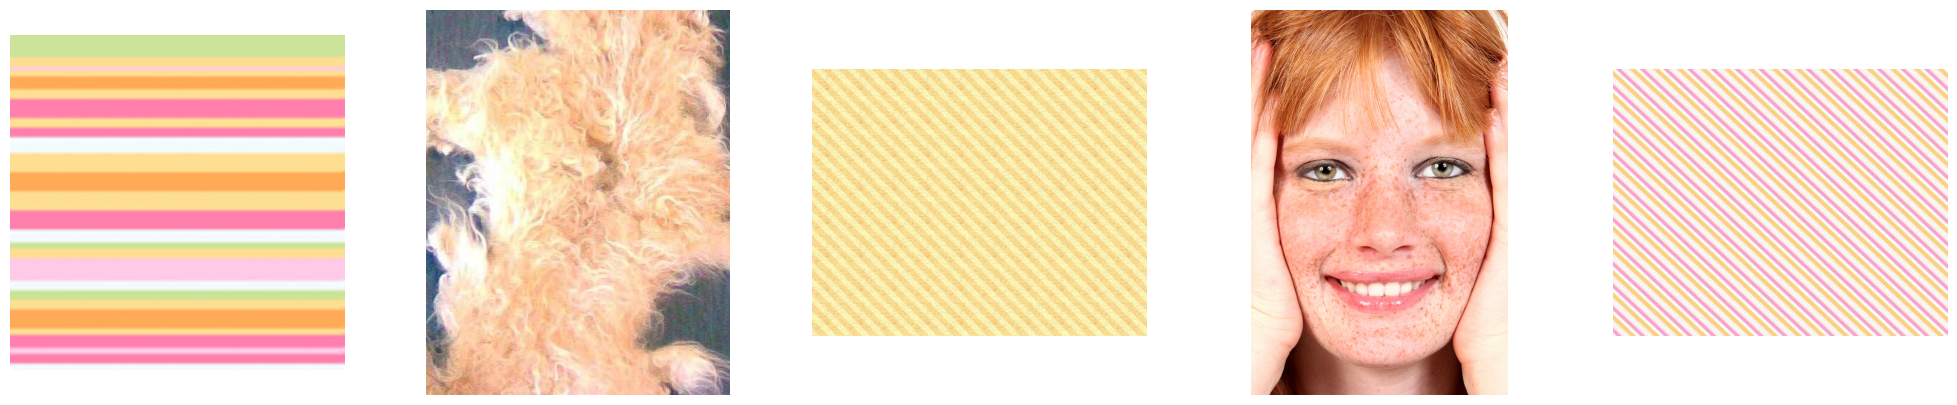

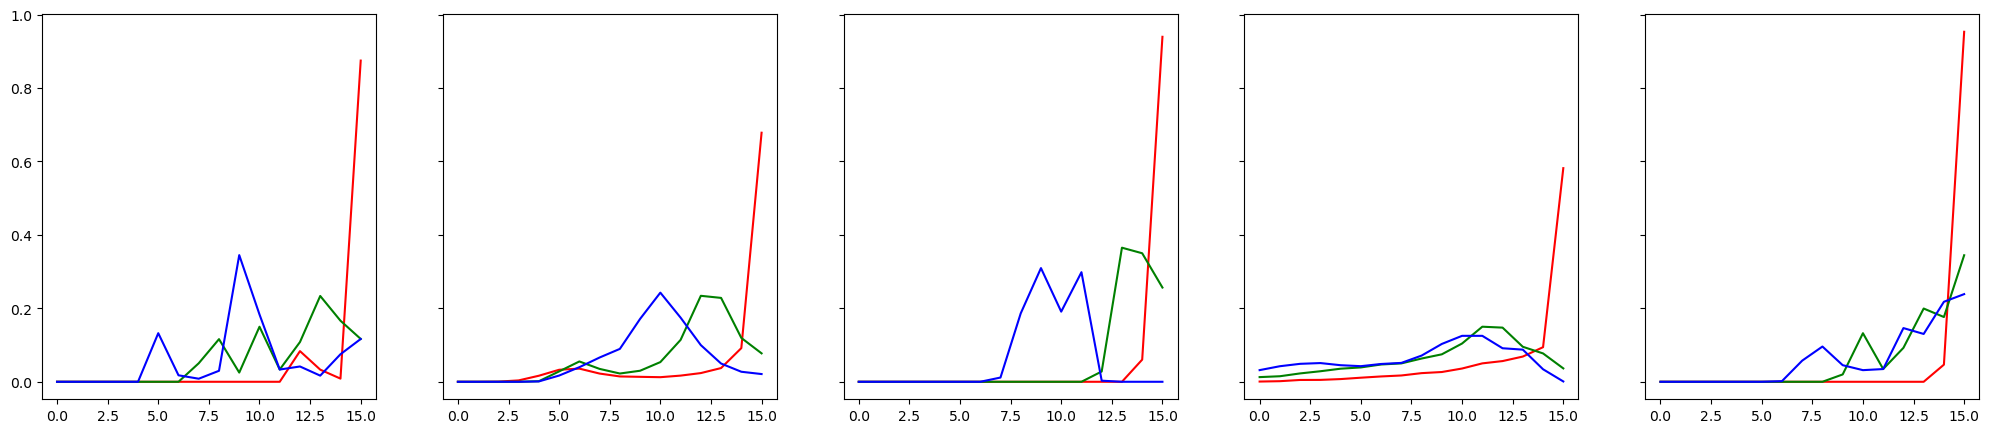

In [ ]:
img = 6
visualize(img, search(img))

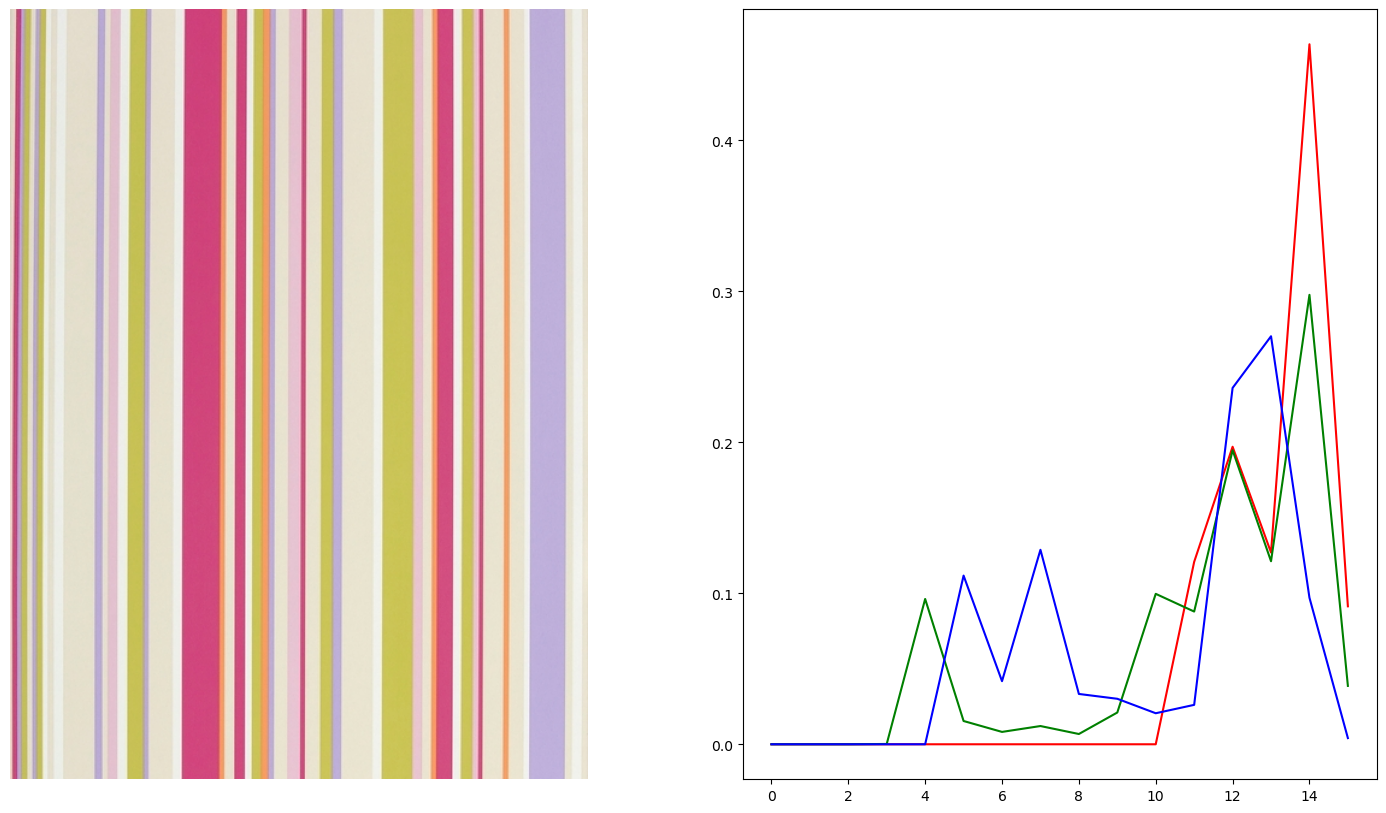

1.1192984580993652

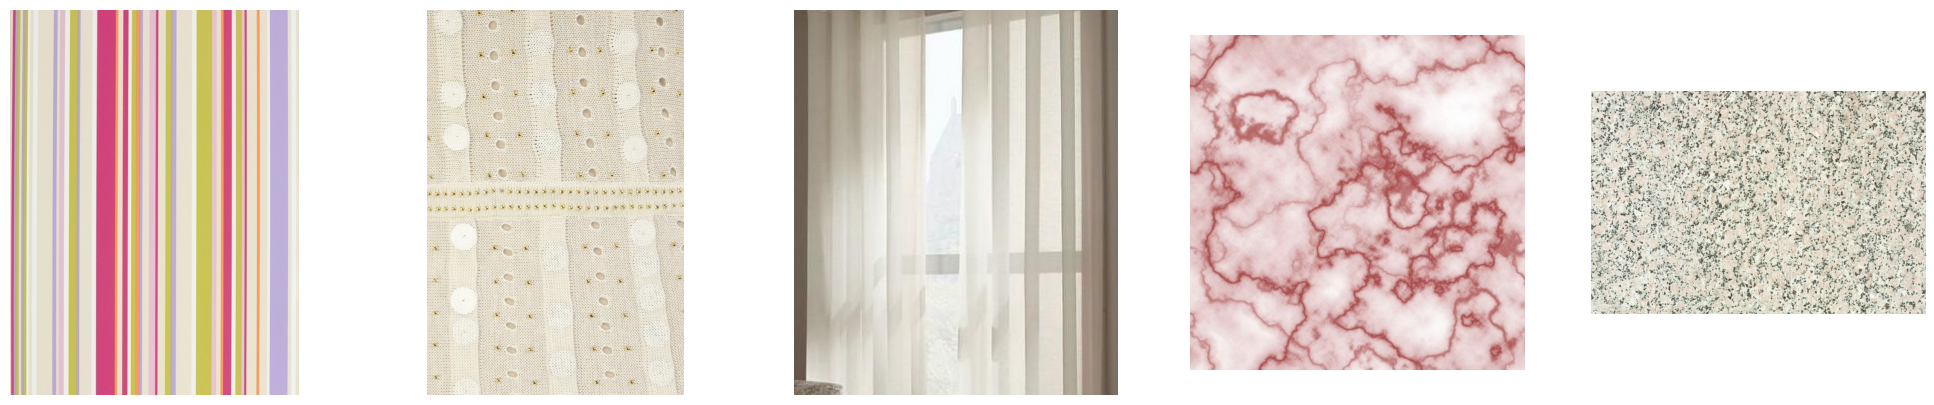

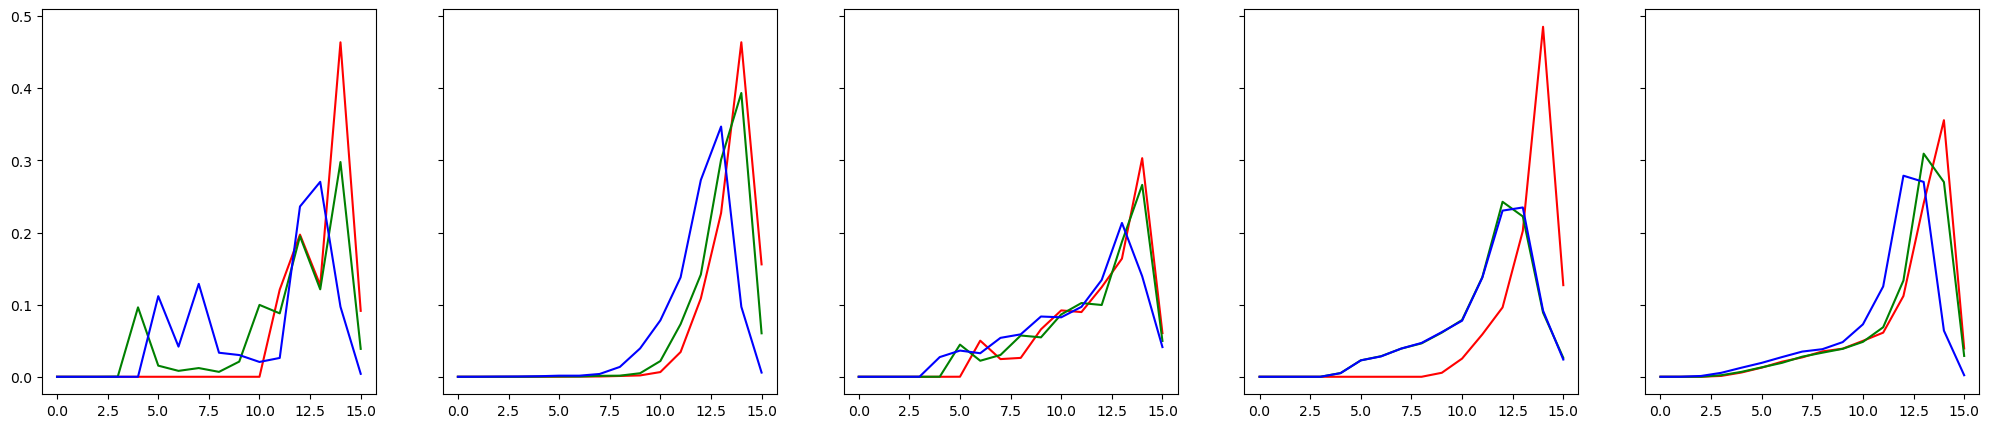

In [ ]:
img = 10
time1=time.time()
visualize(img, search(img))
time2=time.time()
time2-time1